In [ ]:
import pandas as pd
import nltk
import spacy
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models

# Initialize spaCy English model
nlp = spacy.load('en_core_web_sm')

# Load the dataset
df = pd.read_csv('tgif-v1.0.tsv', sep='\t', header=None, names=['gif_url', 'description'])

# Display the first few rows
print(df.head())


                                             gif_url  \
0  https://38.media.tumblr.com/9f6c25cc350f12aa74...   
1  https://38.media.tumblr.com/9ead028ef62004ef6a...   
2  https://38.media.tumblr.com/9f43dc410be85b1159...   
3  https://38.media.tumblr.com/9f659499c8754e40cf...   
4  https://38.media.tumblr.com/9ed1c99afa7d714118...   

                                         description  
0  a man is glaring, and someone with sunglasses ...  
1           a cat tries to catch a mouse on a tablet  
2                   a man dressed in red is dancing.  
3     an animal comes close to another in the jungle  
4  a man in a hat adjusts his tie and makes a wei...  


In [ ]:
import string
from nltk.corpus import stopwords

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_description'] = df['description'].apply(preprocess_text)

print(df[['description', 'clean_description']].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                         description  \
0  a man is glaring, and someone with sunglasses ...   
1           a cat tries to catch a mouse on a tablet   
2                   a man dressed in red is dancing.   
3     an animal comes close to another in the jungle   
4  a man in a hat adjusts his tie and makes a wei...   

                        clean_description  
0  man glaring someone sunglasses appears  
1            cat tries catch mouse tablet  
2                 man dressed red dancing  
3       animal comes close another jungle  
4    man hat adjusts tie makes weird face  


[('man', 51058), ('woman', 25044), ('girl', 10587), ('young', 10175), ('two', 9880), ('hair', 9189), ('wearing', 8624), ('head', 7115), ('dancing', 6491), ('black', 6319), ('another', 5946), ('guy', 5757), ('men', 5635), ('around', 5600), ('boy', 5543), ('person', 5541), ('smiling', 5525), ('talking', 5454), ('looking', 5342), ('white', 5280)]


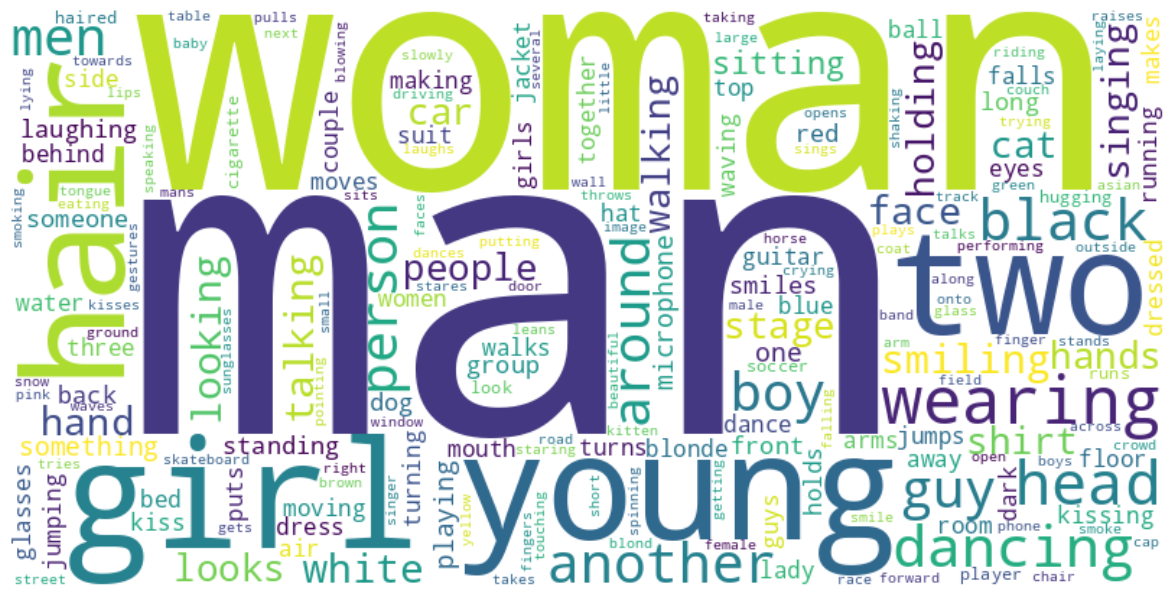

In [ ]:
# Tokenize all descriptions
all_words = ' '.join(df['clean_description']).split()
word_freq = Counter(all_words)

# Display the 20 most common words
print(word_freq.most_common(20))

# Create a word cloud for visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=100)  # Adjust max_features as needed
tfidf_matrix = tfidf.fit_transform(df['clean_description'])

# Get feature names
feature_names = tfidf.get_feature_names_out()

# Convert to DataFrame for better readability
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Sum TF-IDF scores for each word across all documents
tfidf_scores = tfidf_df.sum().sort_values(ascending=False)

# Display top 20 TF-IDF scores
print(tfidf_scores.head(50))


man           17837.535392
woman         10811.430907
girl           5216.269411
young          4913.003020
two            4717.462864
hair           4231.272735
wearing        4003.946853
head           3694.568868
dancing        3450.928230
person         3278.557795
guy            3166.580251
boy            3091.916405
black          3068.112566
looking        3028.185566
smiling        3011.152038
around         2969.626165
men            2955.351505
another        2953.827450
talking        2933.903024
car            2710.268775
white          2708.452233
hand           2671.218555
face           2657.255816
cat            2601.076868
looks          2567.887326
people         2531.870585
walking        2431.090510
holding        2398.335234
stage          2384.685258
singing        2364.030235
hands          2263.253719
something      2253.950855
shirt          2247.194225
sitting        2231.947981
playing        2111.824305
microphone     2055.117998
someone        1991.104990
s

In [ ]:
def extract_entities(text):
    doc = nlp(text)
    return [ent.label_ for ent in doc.ents]

df['entities'] = df['description'].apply(extract_entities)

# Flatten the list of entities and count them
all_entities = [entity for sublist in df['entities'] for entity in sublist]
entity_freq = Counter(all_entities)

print(entity_freq)


Counter({'CARDINAL': 14717, 'NORP': 1102, 'PERSON': 326, 'ORDINAL': 211, 'TIME': 185, 'ORG': 151, 'DATE': 147, 'GPE': 78, 'QUANTITY': 46, 'LOC': 28, 'PRODUCT': 15, 'FAC': 12, 'MONEY': 4})


In [ ]:
# Tokenize and prepare data for LDA
tokenized_descriptions = df['clean_description'].apply(lambda x: x.split())

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(tokenized_descriptions)
corpus = [dictionary.doc2bow(text) for text in tokenized_descriptions]

# Build LDA model
num_topics = 20  # Adjust based on data
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

# Display the topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx+1}: {topic}\n")


Topic 1: 0.251*"two" + 0.135*"men" + 0.082*"one" + 0.056*"together" + 0.044*"kissing" + 0.044*"people" + 0.039*"girls" + 0.029*"couple" + 0.029*"women" + 0.024*"hugging"

Topic 2: 0.095*"away" + 0.091*"man" + 0.049*"riding" + 0.040*"runs" + 0.037*"skateboard" + 0.035*"finger" + 0.035*"woman" + 0.030*"takes" + 0.030*"kisses" + 0.029*"guy"

Topic 3: 0.101*"man" + 0.081*"side" + 0.065*"walks" + 0.059*"dressed" + 0.047*"top" + 0.046*"street" + 0.040*"sat" + 0.039*"woman" + 0.039*"head" + 0.039*"shaking"

Topic 4: 0.209*"holding" + 0.082*"man" + 0.070*"lady" + 0.046*"cigarette" + 0.046*"smoking" + 0.042*"woman" + 0.038*"speaking" + 0.030*"young" + 0.024*"hands" + 0.021*"blows"

Topic 5: 0.208*"man" + 0.149*"another" + 0.046*"woman" + 0.045*"running" + 0.038*"falls" + 0.030*"jumping" + 0.027*"chair" + 0.025*"holds" + 0.020*"ground" + 0.018*"guy"

Topic 6: 0.105*"group" + 0.094*"front" + 0.086*"people" + 0.051*"man" + 0.046*"glasses" + 0.041*"dance" + 0.038*"crowd" + 0.034*"makes" + 0.034*"da

In [ ]:
# Example: Define categories based on frequent words and entities

# 1. Using frequency analysis to define categories
common_words = [word for word, freq in word_freq.items() if freq > 20]  # Threshold can be adjusted

# 2. Using entities to define categories
common_entities = [ent for ent, freq in entity_freq.items() if freq > 10]  # Threshold can be adjusted

# Combine into a set of potential categories
dynamic_categories = set(common_words + common_entities)

print("Dynamic Categories Identified:")
print(dynamic_categories)


Dynamic Categories Identified:
{'piece', 'ballerinas', 'weights', 'yard', 'piercing', 'bunny', 'studio', 'takes', 'tiny', 'gymnast', 'cape', 'hockey', 'women', 'wrestling', 'ladies', 'disappears', 'staring', 'tattooed', 'elevator', 'celebrates', 'performing', 'sad', 'sucks', 'seen', 'slips', 'competition', 'rapping', 'sports', 'figure', 'haired', 'victory', 'form', 'subway', 'smart', 'fashioned', 'placed', 'remove', 'hides', 'cool', 'womans', 'younger', 'pulled', 'photo', 'cartoon', 'bats', 'handsome', 'pole', 'sang', 'tries', 'banging', 'squirrel', 'strumming', 'lovers', 'octopus', 'passionately', 'beneath', 'magic', 'toys', 'knock', 'photographer', 'field', 'telling', 'talk', 'balcony', 'filled', 'student', 'cutting', 'lipstick', 'weird', 'dogs', 'body', 'done', 'straight', 'bench', 'lift', 'teddy', 'leash', 'fringe', 'dark', 'gray', 'shaped', 'tires', 'crazy', 'glove', 'blue', 'paw', 'golf', 'chested', 'fat', 'boarder', 'locker', 'tutu', 'lion', 'river', 'uniforms', 'shower', 'explo

In [ ]:
def assign_categories(description, categories):
    assigned = []
    for category in categories:
        if category.lower() in description.lower():
            assigned.append(category)
    return assigned if assigned else ['Uncategorized']

df['assigned_categories'] = df['description'].apply(lambda x: assign_categories(x, dynamic_categories))

# Display sample assignments
print(df[['description', 'assigned_categories']].head())


                                         description  \
0  a man is glaring, and someone with sunglasses ...   
1           a cat tries to catch a mouse on a tablet   
2                   a man dressed in red is dancing.   
3     an animal comes close to another in the jungle   
4  a man in a hat adjusts his tie and makes a wei...   

                                 assigned_categories  
0  [appears, sunglasses, ears, man, ring, appear,...  
1  [tries, table, mouse, us, cat, tablet, let, ca...  
2                [man, red, dress, dancing, dressed]  
3              [come, comes, another, animal, close]  
4  [weird, hi, man, hat, makes, us, make, face, a...  


Counter({'man': 67012, 'hi': 48763, 'woman': 24851, 'air': 13474, 'ear': 12201, 'ring': 12121, 'one': 12121, 'girl': 11438, 'hair': 11301, 'look': 10622, 'sing': 10285, 'young': 9900, 'two': 9820, 'hand': 9414, 'wear': 9032, 'head': 8695, 'wearing': 8552, 'men': 7693, 'round': 7131, 'walk': 6758, 'lay': 6734, 'old': 6519, 'guy': 6516, 'dancing': 6468, 'talk': 6357, 'hit': 6330, 'boy': 6254, 'black': 6194, 'play': 6030, 'car': 5963, 'another': 5934, 'us': 5874, 'FAC': 5850, 'hold': 5655, 'face': 5585, 'around': 5566, 'PERSON': 5551, 'person': 5551, 'smiling': 5514, 'talking': 5451, 'looking': 5318, 'phone': 5201, 'whit': 5159, 'white': 5139, 'shirt': 5099, 'sit': 5046, 'red': 5030, 'cat': 4667, 'people': 4498, 'hands': 4487, 'thin': 4475, 'low': 4402, 'row': 4344, 'tan': 4334, 'thing': 4318, 'looks': 4294, 'singing': 4290, 'holding': 4242, 'mic': 4220, 'stage': 4209, 'laying': 4086, 'kiss': 4070, 'walking': 4030, 'turn': 3970, 'microphone': 3926, 'back': 3873, 'sitting': 3832, 'stand': 

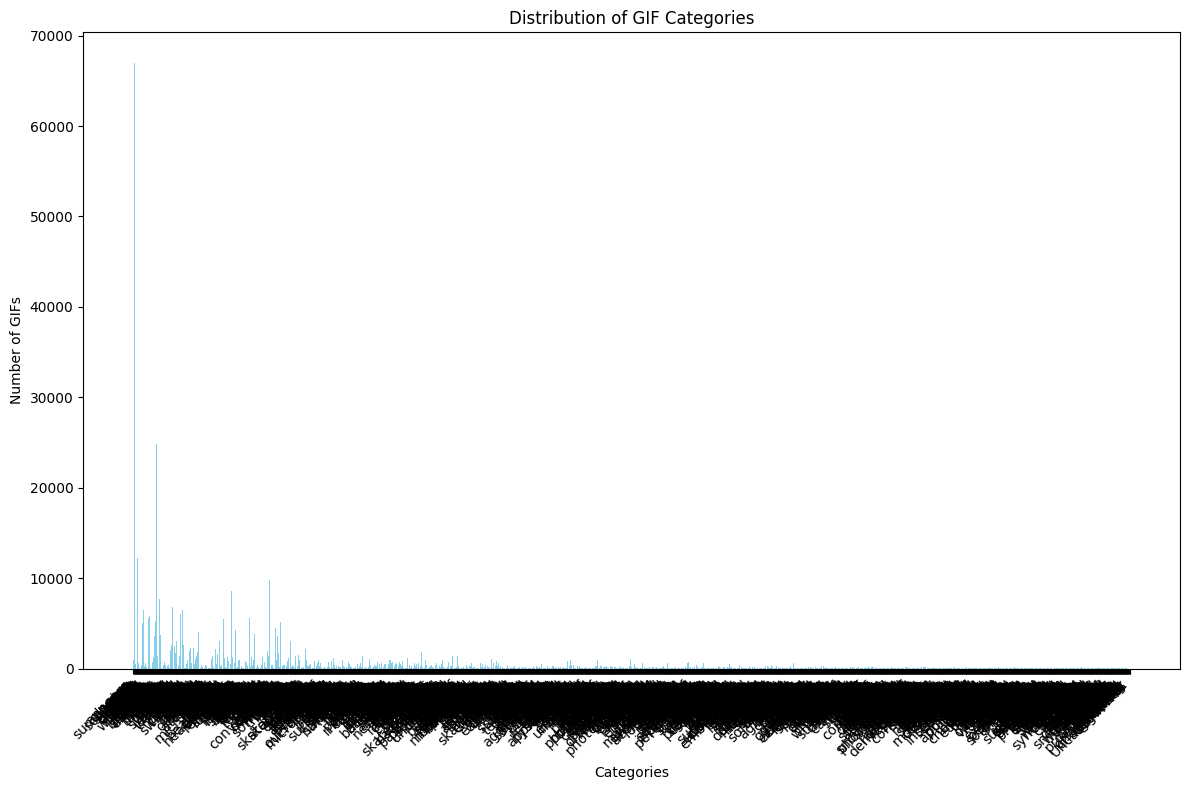

In [ ]:
# Flatten the list of assigned categories
all_assigned = [category for sublist in df['assigned_categories'] for category in sublist]
assigned_counts = Counter(all_assigned)

print(assigned_counts)

# Plotting the distribution
categories = list(assigned_counts.keys())
counts = list(assigned_counts.values())

plt.figure(figsize=(12, 8))
plt.bar(categories, counts, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Number of GIFs')
plt.title('Distribution of GIF Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
from nltk import ngrams

def extract_ngrams(text, n=2):
    tokens = text.split()
    return [' '.join(gram) for gram in ngrams(tokens, n)]

df['bigrams'] = df['clean_description'].apply(lambda x: extract_ngrams(x, n=2))

# Flatten and count bigrams
all_bigrams = [bigram for sublist in df['bigrams'] for bigram in sublist]
bigram_freq = Counter(all_bigrams)

# Define a threshold to consider bigrams as categories
common_bigrams = [bigram for bigram, freq in bigram_freq.items() if freq > 1]


In [ ]:
from gensim.models import Word2Vec

# Train Word2Vec model
w2v_model = Word2Vec(tokenized_descriptions, vector_size=100, window=5, min_count=1, workers=4)

# Find similar words
similar_to_man = w2v_model.wv.most_similar('man', topn=10)
print(similar_to_man)


[('person', 0.8196528553962708), ('guy', 0.7463607788085938), ('boy', 0.6416919827461243), ('woman', 0.61469966173172), ('tie', 0.6000943183898926), ('teenager', 0.5837502479553223), ('lady', 0.5743855237960815), ('kid', 0.568300724029541), ('mesh', 0.5427278280258179), ('thoughtful', 0.53939288854599)]
